# Allstate Claims Severity Data Analysis

The data is from Kaggle's competition, and there is no explaination about the variables, which means we may not see any potential relationship between variables. However, by using machine learing method, XGBoost in this paper, we may get the good model to predict the loss here.

<img src="datakaggle.png",width=600,height=600>

## 1. Load the data and packages

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.cross_validation import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sys

In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.cross_validation import KFold,train_test_split

In [4]:
#load the data
train = pd.read_csv('train.csv',delimiter=',')
test = pd.read_csv('test.csv', delimiter=",")

In [11]:
print('dim(test):',test.shape)
print('dim(train):',train.shape)

dim(test): (125546, 131)
dim(train): (188318, 133)


## 2. data clean and EDA

In [12]:
train.describe()
#already clean the data by checking null

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,log_loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686,7.685268
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186,0.811868
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000,-0.400478
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000,7.093787
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000,7.657080
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000,8.259470
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000,11.703647


In [36]:
pd.isnull(train).values.any()
#no null values, which is good

False

In [37]:
train.info()
#15 kinds of continous values,116 categories

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [14]:
cat_feature = list(train.select_dtypes(include=['object']).columns)
cont_feature = [cont for cont in list(train.select_dtypes(include=['float64','int64']).columns)if cont not in ['loss','id']]
id_col = list(train.select_dtypes(include=['int64']).columns)

In [43]:
id_col

['id']

In [44]:
#check categories
cat_uniques = []
for i in cat_feature:
    cat_uniques.append(len(train[i].unique()))
uniqueValue = pd.DataFrame.from_items([('cat_name',cat_feature),('uniqueValue',cat_uniques)])

In [46]:
uniqueValue.head()

,cat_name,uniqueValue
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


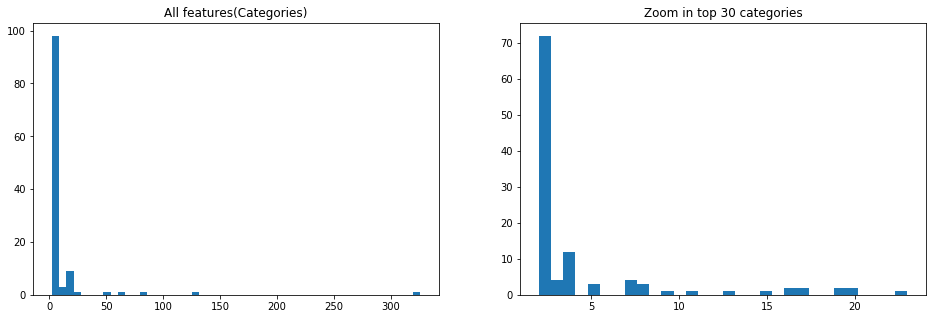

In [53]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniqueValue.uniqueValue,bins=50)
ax2.hist(uniqueValue[uniqueValue.uniqueValue<=30].uniqueValue,bins=30)
ax1.set_title('All features(Categories)')
ax2.set_title('Zoom in top 30 categories')
#most of categories are binary (72/116), one categories value is 326 values(which may represent a daily value)

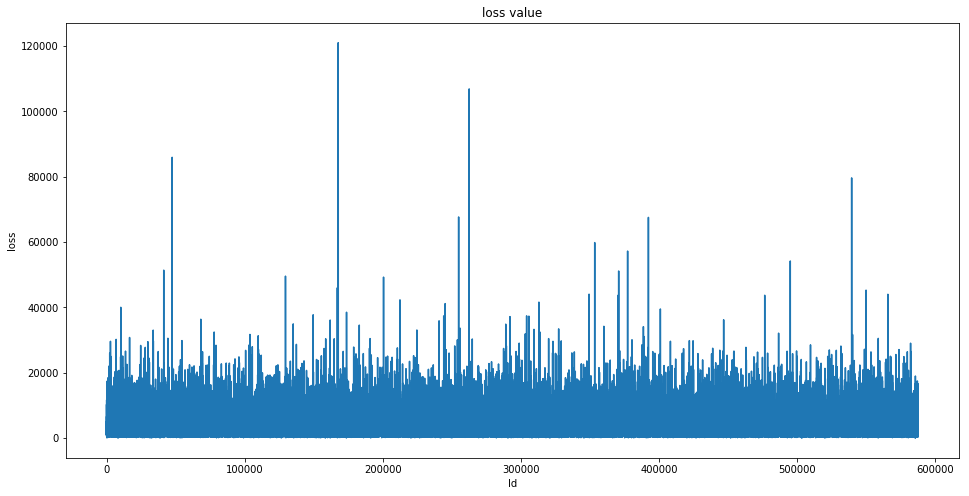

In [56]:
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
plt.title('loss value')
plt.xlabel('Id');plt.ylabel('loss')
#see the distribution of loss

In [57]:
#check the skewness
stats.mstats.skew(train['loss'])
#value=3.79-> right skew

masked_array(data = 3.7949281496777445,
             mask = False,
       fill_value = 1e+20)

In [58]:
stats.mstats.skew(np.log(train['loss']))
#better if we do log-transformation

masked_array(data = 0.0929738049841997,
             mask = False,
       fill_value = 1e+20)

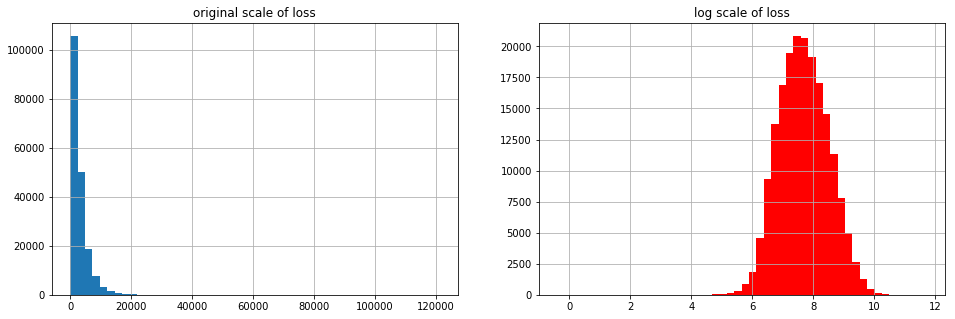

In [62]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'],bins=50)
ax1.set_title('original scale of loss')
ax2.hist(np.log(train['loss']),bins=50,color='r')
ax2.set_title('log scale of loss')
ax1.grid(True)
ax2.grid(True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1123a1470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1ab4fe10>]], dtype=object)

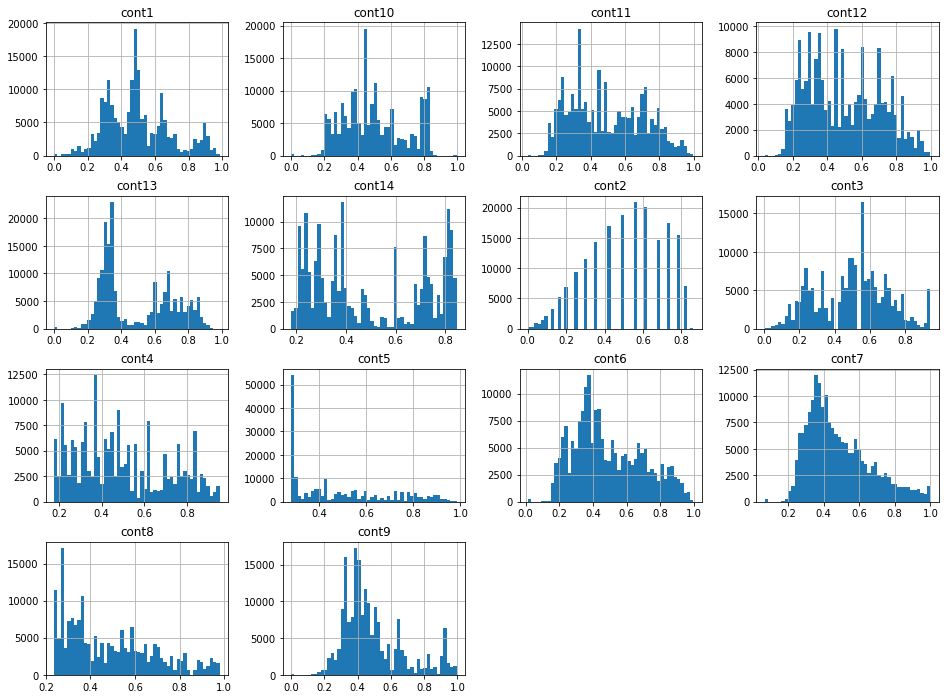

In [63]:
#how about the continous values?
train[cont_feature].hist(bins=50,figsize=(16,12))

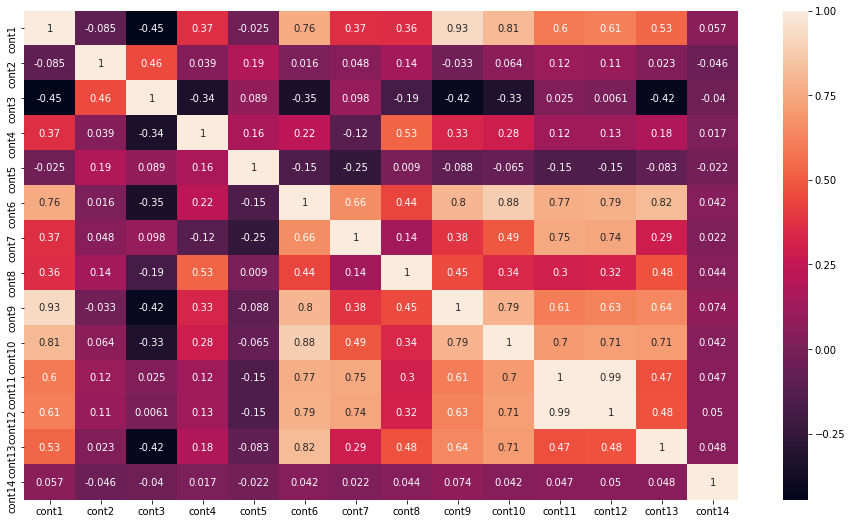

In [65]:
#check correlation
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_feature].corr()
sns.heatmap(correlation_mat,annot=True)

In [6]:
#reduce the dimension of the data [delete the features that have the larger correlation]
#do log to loss first
train['log_loss'] = np.log(train['loss'])


In [68]:
#delete corr >0.85 speed up the algothrithms
train = train.drop(['cont9','cont10','cont11'],axis=1)

In [69]:
#define a method to see how good the model will be
def xg_evaluation(yhat,dtrain):
    y = dtrain.get_label()
    return 'MAE', mean_absolute_error(np.exp(y),np.exp(yhat))

In [70]:
features = [x for x in train.columns if x not in ['id','loss','log_loss']]

In [71]:
#encode
ntrain = train.shape[0]
train_x = train[features]
train_y = train['log_loss']
for i in range(len(cat_feature)):
    train_x[cat_feature[i]] = train_x[cat_feature[i]].astype('category').cat.codes

## 3. Fit the XGBoost Model 

In [72]:
#XGB model
dtrain = xgb.DMatrix(train_x,train['log_loss'])

In [18]:
#parameter in xgboost
#https://xgboost.readthedocs.io/en/latest/parameter.html

In [73]:
xgb_parameter = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'slient':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}

In [74]:
#cross-validation
bst_cv1 = xgb.cv(xgb_parameter,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:10:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
bst_cv1.head()

,test-MAE-mean,test-MAE-std,test-rmse-mean,test-rmse-std,train-MAE-mean,train-MAE-std,train-rmse-mean,train-rmse-std
0,3033.952800,17.058578,6.515028,0.005121,3033.952962,8.528325,6.515003,0.002151
1,3030.861898,17.057330,5.870515,0.004851,3030.861898,8.527774,5.870516,0.002215
2,3025.704508,17.055153,5.290827,0.004997,3025.704264,8.525281,5.290779,0.001914
3,3017.609782,17.053210,4.770086,0.005142,3017.608398,8.518351,4.770014,0.001623
4,3005.566081,17.037218,4.302148,0.004988,3005.561361,8.517872,4.301959,0.001577


In [76]:
print('cv score',bst_cv1.iloc[-1:]['test-MAE-mean'])
#MAE = 1218.38

cv score 49    1218.389241
Name: test-MAE-mean, dtype: float64


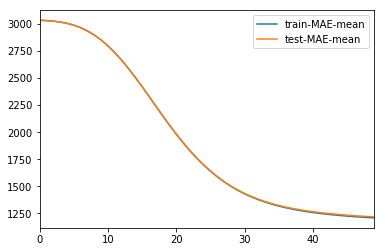

In [77]:
plt.figure()
bst_cv1[['train-MAE-mean','test-MAE-mean']].plot()
#no overfitting for this case

In [78]:
#we now use 100 trees to estimate
bst_cv2 = xgb.cv(xgb_parameter,dtrain,num_boost_round=100,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:11:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
print('cv score',bst_cv2.iloc[-1:]['test-MAE-mean'])

cv score 99    1170.643555
Name: test-MAE-mean, dtype: float64


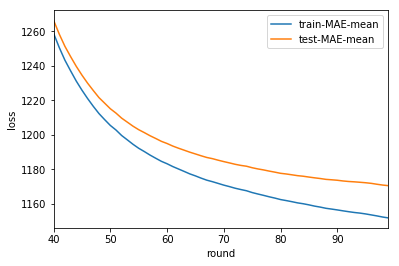

In [80]:
plt.figure()
ax = bst_cv2.iloc[40:][['train-MAE-mean','test-MAE-mean']].plot()
ax.set_xlabel('round')
ax.set_ylabel('loss')
#better than the first round, but a little bit overfitting.

## 4. Steps for tuning
### step1:choose inital parameters
### step2:change max_depth and min_child_weight
### step3:change gamma to lower the overfitting
### step4:change subsample and colsample_bytree, [change sampling strategy]
### step5 change learning rate eta

In [81]:
def mea_score(y_true,y_pred):
    return mean_absolute_error(np.exp(y_true),np.exp(y_pred))

In [82]:
#recall our initial
xgb_parameter = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'slient':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}
#after trying combination for max_depth and min_child_weight,I have checked that when max_depth=8,min_child_weight=6 will be best


In [83]:
xgb_parameter_v1 = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'slient':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':8,
    'min_child_weight':6
}

In [84]:
bst_cv3 = xgb.cv(xgb_parameter_v1,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:12:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [85]:
print('cv score',bst_cv3.iloc[-1:]['test-MAE-mean'])

cv score 49    1187.414632
Name: test-MAE-mean, dtype: float64


In [ ]:
#so,we can see that the change for tree nodes and leaf will increase the model performance
#step3
#next, we need change gamma value, which can lower the overfitting risk
#after trying 0.1-0.5 gamma, we use 0.3 gamma to fit the model

In [92]:
xgb_parameter_v2 = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'slient':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':8,
    'min_child_weight':6,
    'gamma':0.3
}

In [93]:
bst_cv4 = xgb.cv(xgb_parameter_v2,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:18:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [94]:
print('cv score',bst_cv4.iloc[-1:]['test-MAE-mean'])

cv score 49    1187.338013
Name: test-MAE-mean, dtype: float64


In [ ]:
#step4
#next will be change the colsample and subsample
#after trying many times, we check colsample =0.8 and subsample = 0.8

In [95]:
xgb_parameter_v3 = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.8,
    'slient':1,
    'subsample':0.8,
    'objective':'reg:linear',
    'max_depth':8,
    'min_child_weight':6,
    'gamma':0.3
}

In [96]:
bst_cv5 = xgb.cv(xgb_parameter_v3,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [97]:
print('cv score',bst_cv5.iloc[-1:]['test-MAE-mean'])

cv score 49    1184.600179
Name: test-MAE-mean, dtype: float64


In [ ]:
#step5, we change eta, which is the learning rate and also we change the number of trees at the same time.
#eta=0.07,and # of trees is 200

In [98]:
xgb_parameter_v4 = {
    'seed':0,
    'eta':0.07,
    'colsample_bytree':0.8,
    'slient':1,
    'subsample':0.8,
    'objective':'reg:linear',
    'max_depth':8,
    'min_child_weight':6,
    'gamma':0.3
}

In [99]:
bst_cv6 = xgb.cv(xgb_parameter_v4,dtrain,num_boost_round=200,nfold=3,seed=0,feval=xg_evaluation,maximize=False,early_stopping_rounds=10)

[20:21:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## 5. Final Model

In [100]:
print('cv score',bst_cv6.iloc[-1:]['test-MAE-mean'])

cv score 199    1148.41272
Name: test-MAE-mean, dtype: float64


In [102]:
#we have our final parameters
xgb_parameter_v4 = {
    'seed':0,
    'eta':0.07,
    'colsample_bytree':0.8,
    'slient':1,
    'subsample':0.8,
    'objective':'reg:linear',
    'max_depth':8,
    'min_child_weight':6,
    'gamma':0.3
}

## 6. Furture Work
### Although I can do more on this tuning process, I will stop here since I just try to show that XGboost is a good method to predict what we want, by tuning the parameters, we may get the more precise model.